In [219]:
import os
import gzip
import optax
import jax
import jax.lax as lax
import jax.numpy as jnp
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from functools import partial
from tqdm.notebook import tqdm
from sklearn.metrics import accuracy_score, top_k_accuracy_score

In [220]:
# !!! Change path if doesn't work for you

DATASET_PATH = "data/fashion-mnist/"
TRAIN_PATH, TEST_PATH = os.path.join(DATASET_PATH, "train-images-idx3-ubyte.gz"), os.path.join(DATASET_PATH, "t10k-images-idx3-ubyte.gz")
TRAIN_LABELS_PATH, TEST_LABELS_PATH = os.path.join(DATASET_PATH, "train-labels-idx1-ubyte.gz"), os.path.join(DATASET_PATH, "t10k-labels-idx1-ubyte.gz")

In [221]:
def load_mnist_data(_path, _offset):

    with gzip.open(_path, "rb") as f:
        data = np.frombuffer(f.read(), np.uint8, offset=_offset)

    return data


class BatchGenerator:

    def __init__(self, X, Y, batch_size):
        self.X = X
        self.Y = Y
        self.batch_size = batch_size
        self.num_batches = (X.shape[0] - 1) // batch_size + 1

    def __iter__(self):
        for i in range(self.num_batches):
            start = i * self.batch_size
            end = start + self.batch_size

            yield self.X[start:end], self.Y[start:end]

In [222]:
TRAIN_LABELS_NP = load_mnist_data(TRAIN_LABELS_PATH, 8)
TRAIN_DATA_NP = (load_mnist_data(TRAIN_PATH, 16).reshape(len(TRAIN_LABELS_NP), 28, 28)).astype(np.float32) / 255.0

# (N, H, W) -> (N, C, H, W)
# (batch, height, width) -> (batch, channels, height, width)
TRAIN_DATA_NP = TRAIN_DATA_NP[:, np.newaxis, :, :]

TEST_LABELS_NP = load_mnist_data(TEST_LABELS_PATH, 8)
TEST_DATA_NP = (load_mnist_data(TEST_PATH, 16).reshape(len(TEST_LABELS_NP), 28, 28)).astype(np.float32) / 255.0

# (N, H, W) -> (N, C, H, W)
# (batch, height, width) -> (batch, channels, height, width)
TEST_DATA_NP = TEST_DATA_NP[:, np.newaxis, :, :]

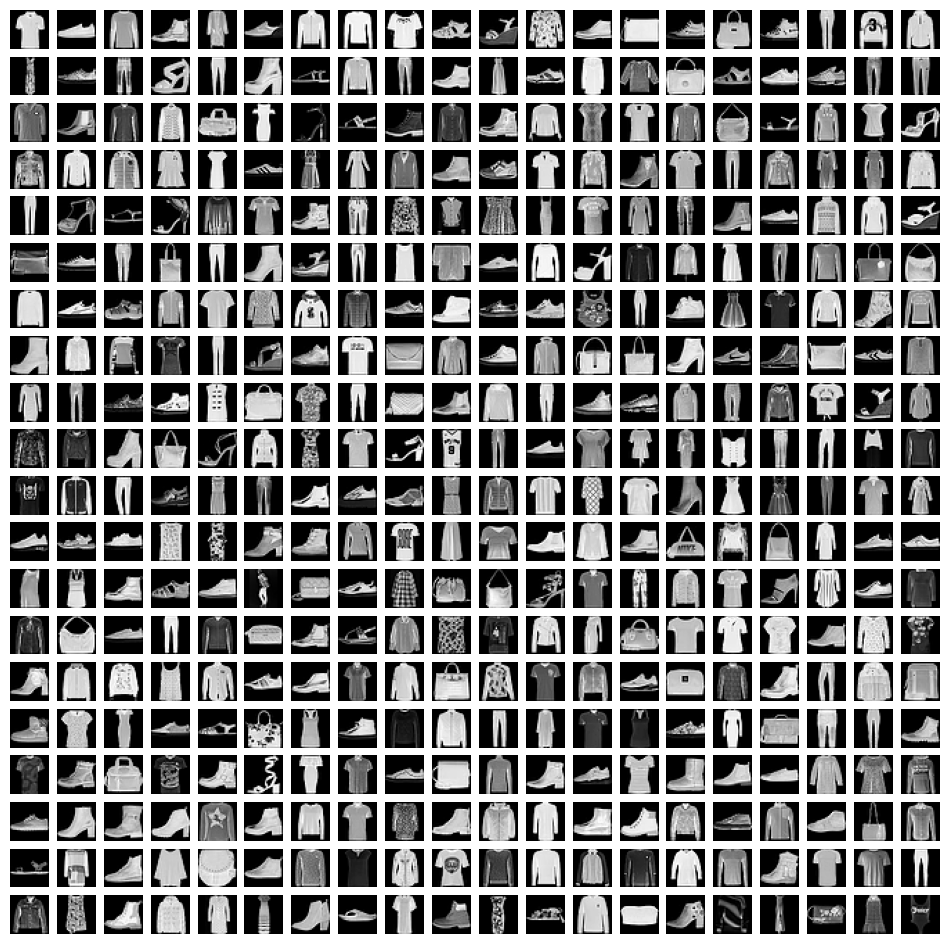

In [223]:
fig, ax = plt.subplots(20, 20, figsize=(12, 12))

for i in range(20):
    for j in range(20):
        ax[i, j].imshow(TRAIN_DATA_NP[np.random.randint(0, len(TRAIN_LABELS_NP), 1).item()][0, :, :], cmap="gray")
        ax[i, j].axis("off")

        ax[i, j].set_xticks([])
        ax[i, j].set_yticks([])

plt.show()

## CNN

In [224]:
def compute_conv_output_shape(lhs, rhs, strides, padding):
    return lax.conv_general_shape_tuple(lhs, rhs, strides, padding, ("NCHW", "HWIO", "NCHW"))


def compute_max_pool_output_shape(lhs, window_shape, strides, padding="VALID"):
    return jax.lax.reduce_window_shape_tuple(
        lhs,
        window_shape,
        strides,
        jax.lax.padtype_to_pads(
            lhs,
            window_shape,
            strides,
            padding
        )
    )

def conv2d_init_weights(filters, kernel_size, input_channel, key):
    shape = (kernel_size, kernel_size, input_channel, filters) # HWIO

    W_init = jax.nn.initializers.glorot_normal(2, 3)
    W = W_init(key, shape)
    b = jnp.zeros((filters,), dtype=jnp.float32)

    return W, b


def dense_init_weights(input_dim, output_dim, key):
    shape = (input_dim, output_dim)

    W_init = jax.nn.initializers.glorot_normal()
    W = W_init(key, shape)
    b = jnp.zeros((output_dim,), dtype=jnp.float32)

    return W, b


@partial(jax.jit, static_argnames=("strides", "padding"))
def conv2d_apply(inputs, W, b, strides, padding):
    return jax.lax.conv_general_dilated(
        inputs,
        W,
        strides,
        padding,
        dimension_numbers=("NCHW", "HWIO", "NCHW")
    ) + b[None, :, None, None]


@partial(jax.jit, static_argnames=("pool_size", "strides", "padding"))
def max_pool_apply(inputs, pool_size, strides, padding='VALID'):
    window_shape = (1, 1, pool_size[0], pool_size[1])
    stride_shape = (1, 1, strides[0], strides[1])

    # Apply max pooling using reduce_window
    return jax.lax.reduce_window(inputs, -jnp.inf, lax.max, window_shape, stride_shape, padding)


@jax.jit
def flatten_apply(inputs):
    return jnp.reshape(inputs, (inputs.shape[0], -1))


@jax.jit
def dense_apply(inputs, W, b):
    return jnp.dot(inputs, W) + b

@jax.jit
def relu(x):
    return jax.nn.relu(x)

@jax.jit
def softmax(x):
    return jax.nn.softmax(x)

@jax.jit
def sigmoid(x):
    return jax.nn.sigmoid(x)

@jax.jit
def tanh(x):
    return jax.nn.tanh(x)

In [225]:
def initialize(params: list[dict], seed: int = 69):
    ret_params, layers_def = [], []

    key, *subkeys = jax.random.split(jax.random.PRNGKey(seed), len(params))

    input_shape = params[0]["shape"]
    output_shapes = [input_shape, ]

    for layer_idx, layer in enumerate(params[1:]):
        layer_type = layer["type"]

        if layer_type == "Conv2D":
            input_shape = output_shapes[-1]

            filters = layer["filters"]
            kernel_shape = (layer["kernel_size"], layer["kernel_size"], input_shape[1], filters)
            strides = layer["strides"]
            padding = layer["padding"]

            output_shape = compute_conv_output_shape(input_shape, kernel_shape, strides, padding)
            output_shapes.append(output_shape)

            W, b = conv2d_init_weights(filters, kernel_shape[0], kernel_shape[2], subkeys[layer_idx])

            layers_def.append({
                "type": layer_type,
                "filters": filters,
                "kernel_size": layer["kernel_size"],
                "strides": strides,
                "padding": padding,
                "activation": layer.get("activation", None)
            })
            ret_params.append({
                "W": W,
                "b": b
            })
        elif layer_type == "MaxPool":
            input_shape = output_shapes[-1]

            pool_size = layer["pool_size"]
            strides = layer["strides"]
            padding = layer["padding"]

            output_shape = compute_max_pool_output_shape(
                input_shape[1:],
                (1, pool_size[0], pool_size[1]),
                (1, strides[0], strides[1]),
                padding
            )

            output_shapes.append((None, ) + output_shape)
            ret_params.append({})
            layers_def.append({
                "type": layer_type,
                "pool_size": pool_size,
                "strides": strides,
                "padding": padding
            })
        elif layer_type == "Dense":
            input_shape = output_shapes[-1]

            units = layer["units"]
            activation = layer["activation"]

            W, b = dense_init_weights(input_shape[1], units, subkeys[layer_idx])

            output_shapes.append((None, units))
            ret_params.append({
                "W": W,
                "b": b
            })
            layers_def.append({
                "type": layer_type,
                "activation": activation
            })
        elif layer_type == "flatten":
            input_shape = output_shapes[-1]
            output_shape = (input_shape[0], np.prod(input_shape[1:]))

            output_shapes.append(output_shape)
            ret_params.append({})
            layers_def.append({
                "type": layer_type
            })

    return ret_params, layers_def, output_shapes


def forward(params, layers_def, inputs):
    x = inputs

    for layer_idx, (layer_params, layer_def) in enumerate(zip(params, layers_def)):
        layer_type = layer_def["type"]

        if layer_type == "Conv2D":
            x = conv2d_apply(x, layer_params["W"], layer_params["b"], layer_def["strides"], layer_def["padding"])

            if layer_def["activation"] == "relu":
                x = relu(x)
            elif layer_def["activation"] == "tanh":
                x = tanh(x)
                
        elif layer_type == "MaxPool":
            x = max_pool_apply(x, layer_def["pool_size"], layer_def["strides"], layer_def["padding"])
        elif layer_type == "flatten":
            x = flatten_apply(x)
        elif layer_type == "Dense":
            activation = layer_def["activation"]
            x = dense_apply(x, layer_params["W"], layer_params["b"])

            if activation == "relu":
                x = relu(x)
            elif activation == "softmax":
                x = softmax(x)
            elif activation == "sigmoid":
                x = sigmoid(x)
            elif activation == "tanh":
                x = tanh(x)

    return x


def loss_fn(params, layers_def, inputs, targets):
    preds = forward(params, layers_def, inputs)    
    targets = jax.nn.one_hot(targets, 10)
    
    return jax.jit(optax.losses.softmax_cross_entropy)(preds, targets).mean()


def update(opt_state, params, layers_def, inputs, targets):
    loss_value, grads = jax.value_and_grad(loss_fn)(params, layers_def, inputs, targets)
    updates, opt_state = optimizer.update(grads, opt_state)
    new_params = optax.apply_updates(params, updates)

    return new_params, opt_state, loss_value

In [228]:
cnn_params = [
    {
        "type": "Input",
        "shape": (None, 1, 28, 28)
    },
    {
        "type": "Conv2D",
        "filters": 32,
        "kernel_size": 5,
        "strides": (1, 1),
        "padding": "SAME",
        "activation": "relu"
    },
    {
        "type": "MaxPool",
        "pool_size": (2, 2),
        "strides": (2, 2),
        "padding": "VALID"
    },
    {
        "type": "Conv2D",
        "filters": 64,
        "kernel_size": 5,
        "strides": (1, 1),
        "padding": "SAME",
        "activation": "relu"
    },
    {
        "type": "MaxPool",
        "pool_size": (2, 2),
        "strides": (2, 2),
        "padding": "VALID"
    },
    {
        "type": "Conv2D",
        "filters": 128,
        "kernel_size": 5,
        "strides": (1, 1),
        "padding": "SAME",
        "activation": "relu"
    },
    {
        "type": "MaxPool",
        "pool_size": (2, 2),
        "strides": (2, 2),
        "padding": "VALID"        
    },
    {
        "type": "flatten"
    },
    {
        "type": "Dense",
        "units": 512,
        "activation": "relu"
    },
    {
        "type": "Dense",
        "units": 256,
        "activation": "relu"
    },
    {
        "type": "Dense",
        "units": 128,
        "activation": "relu"
    },    
    {
        "type": "Dense",
        "units": 10,
        "activation": "softmax"
    }
]

params, layers_definitions, output_shapes = initialize(cnn_params)

batch_size = 256
iterations = 250
learning_rate = 1e-4

# get train and validation indices
np.random.seed(42)
indices = np.random.permutation(len(TRAIN_LABELS_NP))

train_indices = indices[:int(0.8 * len(TRAIN_LABELS_NP))]
val_indices = indices[int(0.8 * len(TRAIN_LABELS_NP)):]

train_batch_generator = BatchGenerator(TRAIN_DATA_NP[train_indices], TRAIN_LABELS_NP[train_indices], batch_size)
val_batch_generator = BatchGenerator(TRAIN_DATA_NP[val_indices], TRAIN_LABELS_NP[val_indices], batch_size // 4)

In [229]:
history = {
    "loss": [],
    "val_loss": [],
    "val_accuracy": [],
    "val_top_3_accuracy": []
}

with tqdm(total=iterations, desc='Training') as pbar:
    optimizer = optax.adam(learning_rate=learning_rate)
    opt_state = optimizer.init(params)

    for _iter in range(iterations):
        
        train_loss = jnp.array(0.0, dtype=jnp.float32)
        for batch_X, batch_Y in train_batch_generator:
            params, opt_state, loss_batch = update(opt_state, params, layers_definitions, batch_X, batch_Y)
            train_loss += loss_batch

        train_loss /= train_batch_generator.num_batches        
        val_accuracy = accuracy_score(
            TRAIN_LABELS_NP[val_indices],
            np.argmax(forward(params, layers_definitions, TRAIN_DATA_NP[val_indices]), axis=1)
        )
        val_top_3_accuracy = top_k_accuracy_score(
            TRAIN_LABELS_NP[val_indices],
            forward(params, layers_definitions, TRAIN_DATA_NP[val_indices]),
            k=3
        )

        val_loss = jnp.array(0.0, dtype=jnp.float32)
        for val_batch_X, val_batch_Y in val_batch_generator:            
            val_loss += loss_fn(params, layers_definitions, val_batch_X, val_batch_Y)
        
        val_loss /= val_batch_generator.num_batches
        
        history["loss"].append(train_loss)
        history["val_loss"].append(val_loss)
        history["val_accuracy"].append(val_accuracy)
        history["val_top_3_accuracy"].append(val_top_3_accuracy)

        pbar.set_postfix({
            "loss": train_loss,
            "val_loss": val_loss,
            "val_accuracy": val_accuracy,
            "val_top_3_accuracy": val_top_3_accuracy
        })
        pbar.update(1)

Training:   0%|          | 0/250 [00:00<?, ?it/s]

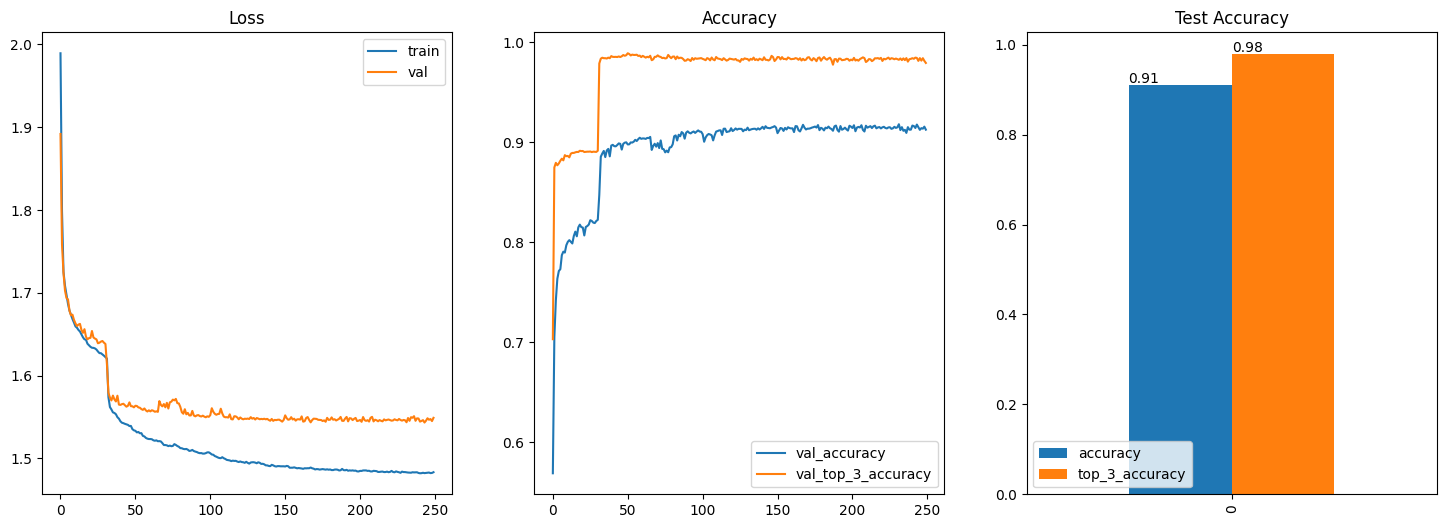

In [230]:
_, loss_ax = plt.subplots(1, 3, figsize=(18, 6))

loss_ax[0].plot(history["loss"], label="train")
loss_ax[0].plot(history["val_loss"], label="val")

loss_ax[1].plot(history["val_accuracy"], label="val_accuracy")
loss_ax[1].plot(history["val_top_3_accuracy"], label="val_top_3_accuracy")

loss_ax[0].set_title("Loss")
loss_ax[1].set_title("Accuracy")

pd.DataFrame({
    "accuracy": [
        accuracy_score(
            TEST_LABELS_NP,
            np.argmax(forward(params, layers_definitions, TEST_DATA_NP), axis=1)
        )
    ],
    "top_3_accuracy": [top_k_accuracy_score(TEST_LABELS_NP, forward(params, layers_definitions, TEST_DATA_NP), k=3)]
}).plot(kind="bar", ax=loss_ax[2])

for p in loss_ax[2].patches:
    loss_ax[2].annotate(str(round(p.get_height(), 2)), (p.get_x() * 1.005, p.get_height() * 1.005))
    
loss_ax[2].legend(loc='lower left')
loss_ax[2].set_title("Test Accuracy")

loss_ax[0].legend()
loss_ax[1].legend()

plt.show()

In [231]:
pd.DataFrame({
    "accuracy": [
        accuracy_score(
            TEST_LABELS_NP,
            np.argmax(forward(params, layers_definitions, TEST_DATA_NP), axis=1)
        )
    ],
    "top_3_accuracy": [top_k_accuracy_score(TEST_LABELS_NP, forward(params, layers_definitions, TEST_DATA_NP), k=3)]
})

,accuracy,top_3_accuracy
0,0.9098,0.9786


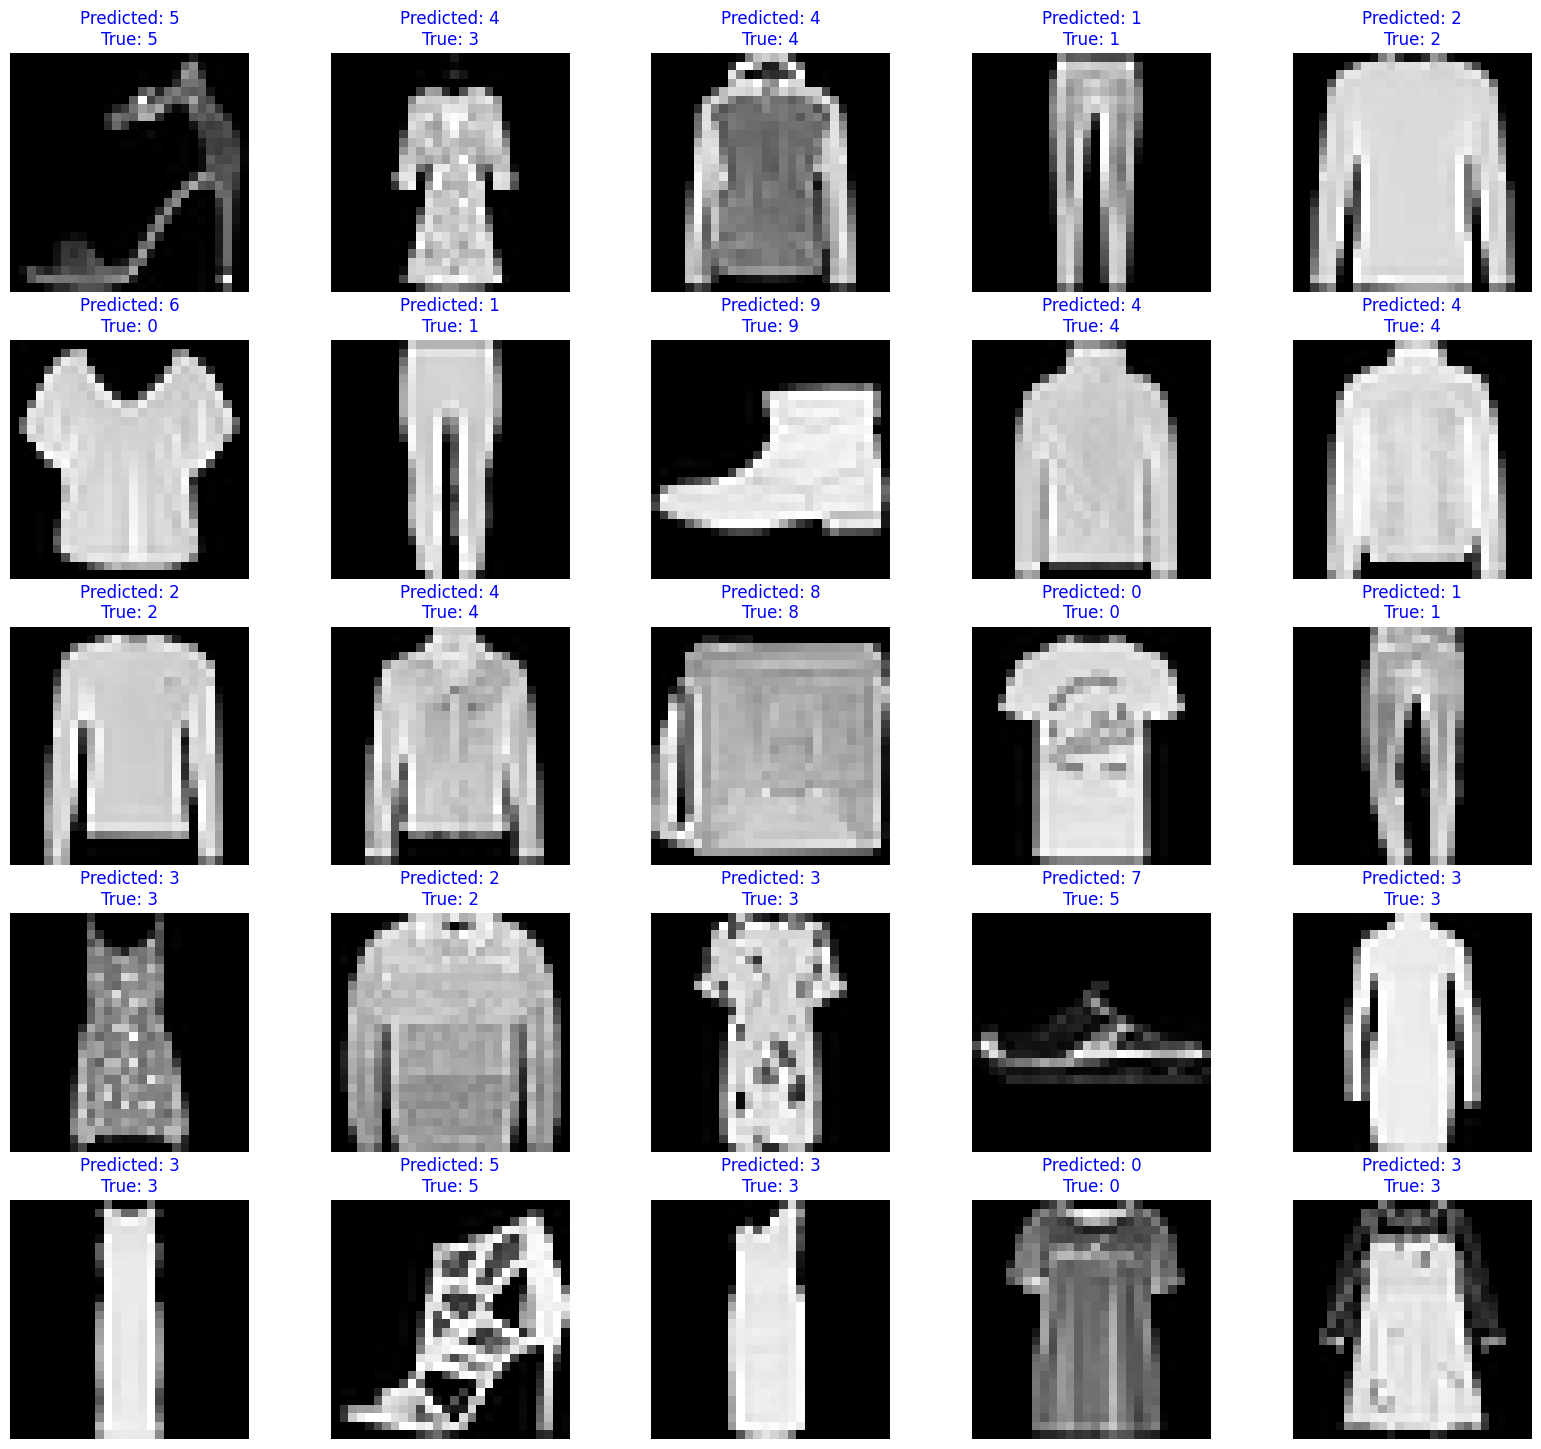

In [232]:
fig, ax = plt.subplots(5, 5, figsize=(20, 18))

for i in range(5):
    for j in range(5):
        idx = np.random.randint(0, len(TEST_LABELS_NP), 1).item()
        ax[i, j].imshow(TEST_DATA_NP[idx].reshape(28, 28), cmap="gray")
        ax[i, j].set_title(f"Predicted: {np.argmax(forward(params, layers_definitions, TEST_DATA_NP[idx:idx+1]), axis=1).item()}\nTrue: {TEST_LABELS_NP[idx]}")
        ax[i, j].axis("off")

        # make margin between images for better visualization
        ax[i, j].set_xticks([])
        ax[i, j].set_yticks([])

        # text color of title make to be blue
        ax[i, j].title.set_color('blue')

plt.show()